In [56]:
import os
import sys

NJET_BLHA='/Users/simon/packages/njet-3.1.1-1L/blha/'
sys.path.append(NJET_BLHA)

import numpy as np
from pstools.rambo import generate, dot
from njettools.njet_interface import *
from nntools.model import Model

import matplotlib.pyplot as plt
%matplotlib inline

In [64]:
# set a BLHA file to provide squared amplitudes via NJe
n_jets = 4;
contract_file = 'NJ_contract_ee'+str(n_jets)+'j.lh'

In [65]:
# choose the number of training points (will later be split into NN train/test set)
n_training_points = 100
delta_cut = 0.01

In [66]:
# generate 2 -> n_jets phase-space points for training
momenta, n_trials = generate(n_jets, n_training_points, rts=1000., delta=delta_cut)
momenta = momenta.tolist()

100%|██████████| 100/100 [00:00<00:00, 2361.05it/s]


In [67]:
# start the NJet interface
olp = njet.OLP()
status = njet_init(contract_file)

if status == True:
    print ("OLP read in correctly")
else:
    print ("seems to be a problem with the contract file...")

OLP read in correctly


In [68]:
mur = 100.
alphas = 0.118
alpha = 1/137.

In [69]:
# demonstrating the evaluation of loop-level matrix element squared
testval0 = olp.OLP_EvalSubProcess(1,
                       momenta[0],
                       alphas=alphas,
                       alpha=alpha,
                       mur=mur,
                       retlen=7)

print("1/eps^2 pole divided by tree", 4*np.pi/alphas*testval0[0]/testval0[3])
print("1/eps^1 pole divided by tree", 4*np.pi/alphas*testval0[1]/testval0[3])

1/eps^2 pole divided by tree -17.33333333333327
1/eps^1 pole divided by tree 23.503414510642347


In [70]:
NJ_loopvals = [];
pbar = tqdm(total=n_training_points)
for pt in range(n_training_points):
    vals = olp.OLP_EvalSubProcess(1, momenta[pt], alphas=alphas, alpha=alpha, mur=mur, retlen=7)
    NJ_loopvals.append(vals[2]/vals[3])
    pbar.update(1)
pbar.close()

100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


In [71]:
# dump generated data in case NJet and interface not available
np.save("NJ_ee"+str(n_jets)+"j_loop_momenta.npy", momenta)
np.save("NJ_ee"+str(n_jets)+"j_loop_values.npy", NJ_loopvals)
n_training_points = len(momenta)

In [72]:
momenta = np.load("NJ_ee"+str(n_jets)+"j_loop_momenta.npy")
NJ_treevals = np.load("NJ_ee"+str(n_jets)+"j_loop_values.npy")

In [73]:
NN = Model(
    (2+n_jets)*4, # train with all momenta components 
    momenta[:n_training_points], # input data from Rambo PS generator
    np.array(NJ_loopvals) # data points from NJet evaluations
)

In [74]:
model, x_mean, x_std, y_mean, y_std = NN.fit(layers=[16,32,16])

processing training data using scaling =  standardise
The training dataset has size (80, 24)
Epoch 1/10000
80/80 [==============================] - 1s 9ms/sample - loss: 1.2583 - val_loss: 1.6413


In [45]:
n_points = 1000
newmomenta, n_trials2 = generate(n_jets, n_points, rts=1000., delta=delta_cut)
newmomenta = newmomenta.tolist()

100%|██████████| 1000/1000 [00:00<00:00, 6286.75it/s]


In [46]:
NJ_loopvals_test = [];
for pt in range(n_points):
    vals = olp.OLP_EvalSubProcess(1, newmomenta[pt], alphas=alphas,alpha=alpha,mur=mur, retlen=7)
    NJ_loopvals_test.append(vals[2]/vals[3])

In [47]:
x_standardized = NN.process_testing_data(moms=newmomenta,x_mean=x_mean,x_std=x_std,y_mean=y_mean,y_std=y_std)

mpred = model.predict(x_standardized)

amp_pred = NN.destandardise_data(mpred.reshape(-1),x_mean=x_mean,x_std=x_std,y_mean=y_mean,y_std=y_std)

diff = (amp_pred-np.array(NJ_loopvals_test))/(amp_pred+np.array(NJ_loopvals_test))

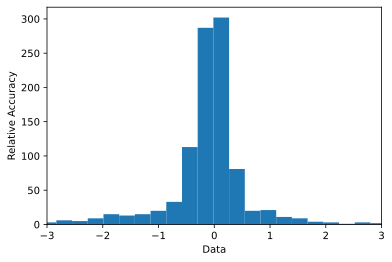

In [53]:
plt.hist(diff, density=False, bins=1000)
plt.xlim([-3,3])
plt.ylabel('Relative Accuracy')
plt.xlabel('Data');

In [54]:
logdiff = np.log10(abs(diff))

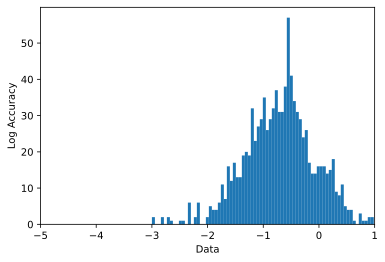

In [55]:
plt.hist(logdiff, density=False, bins=100)
plt.xlim([-5,1])
plt.ylabel('Log Accuracy')
plt.xlabel('Data');